# Data load

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
print(train.isnull().sum().sort_values(ascending=False))

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


In [5]:
print(test.isnull().sum().sort_values(ascending=False))

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


# EDA

상관관계 분석

In [6]:
corr_matrix = train.corr()
corr_matrix

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


<Axes: >

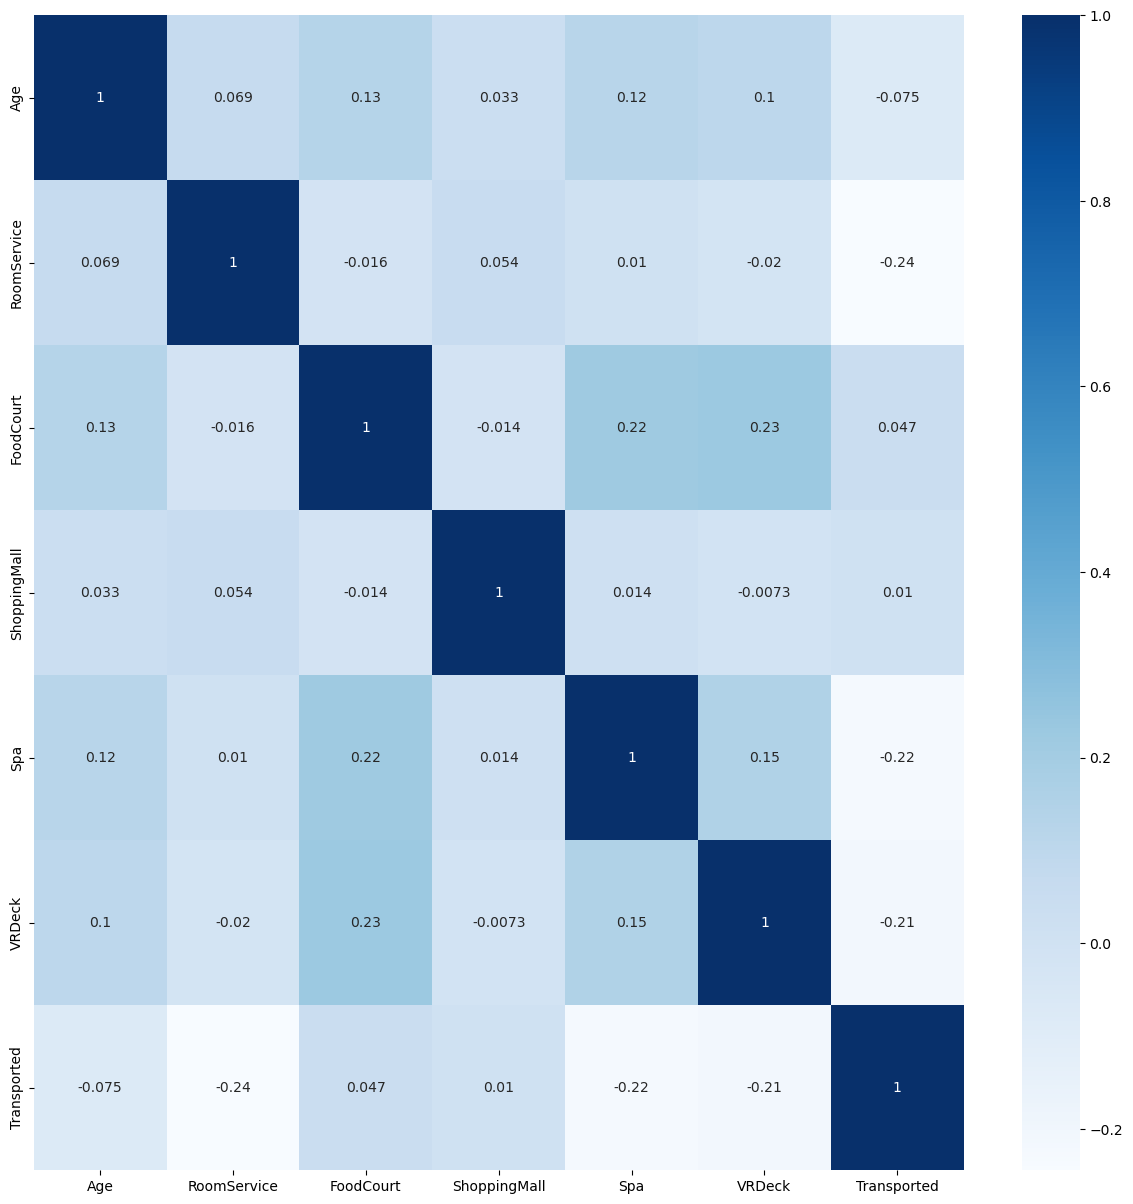

In [7]:
plt.figure(figsize=(15,15))
sns.heatmap(data = corr_matrix, annot=True,cmap='Blues')

# Data Preprocessing

In [8]:
# 중요하지 않은 변수 삭제
train.drop(['PassengerId','Name'],axis =1 ,inplace=True)
test.drop(['PassengerId','Name'],axis =1 ,inplace=True)

In [9]:
# Cabin 변수로 다른 변수 생성
train[['deck','num','side']] = train['Cabin'].str.split('/', expand= True)
test[['deck','num','side']] = test['Cabin'].str.split('/', expand= True)

train.drop(['Cabin','num'],axis =1 ,inplace=True)
test.drop(['Cabin','num'],axis =1 ,inplace=True)

In [10]:
imputer = SimpleImputer(strategy='most_frequent')

imputer.fit_transform(train[['Destination','VIP','CryoSleep','deck','side']])
train[['Destination','VIP','CryoSleep','deck','side']] = imputer.transform(train[['Destination','VIP','CryoSleep','deck','side']])

imputer.fit_transform(test[['Destination','VIP','CryoSleep','deck','side']])
test[['Destination','VIP','CryoSleep','deck','side']] = imputer.transform(test[['Destination','VIP','CryoSleep','deck','side']])

In [11]:
imputer2 = SimpleImputer(strategy='constant',fill_value=0)
imputer2.fit_transform(train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']])
train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = imputer2.transform(train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']])

imputer2.fit_transform(test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']])
test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = imputer2.transform(test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']])

In [12]:
#새로운 consume 변수 생성
train['consume'] = train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
test['consume'] = test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

In [13]:
#homeplanet에 따라 age 채우기 
train['Age'] = train.groupby('HomePlanet')['Age'].transform(lambda x: x.fillna(x.median()))
test['Age'] = test.groupby('HomePlanet')['Age'].transform(lambda x: x.fillna(x.median()))

In [14]:
#missing data 0으로 채우기
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [15]:
#one-hot encoding
train_one = pd.get_dummies(train, columns=['HomePlanet','CryoSleep','Destination','VIP','deck','side'], drop_first=True)
test_one = pd.get_dummies(test, columns=['HomePlanet','CryoSleep','Destination','VIP','deck','side'], drop_first=True)

train_one['Transported'].replace({True:1,False:0},inplace=True)

In [16]:
train_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        8693 non-null   float64
 1   RoomService                8693 non-null   float64
 2   FoodCourt                  8693 non-null   float64
 3   ShoppingMall               8693 non-null   float64
 4   Spa                        8693 non-null   float64
 5   VRDeck                     8693 non-null   float64
 6   Transported                8693 non-null   int64  
 7   consume                    8693 non-null   float64
 8   HomePlanet_Earth           8693 non-null   uint8  
 9   HomePlanet_Europa          8693 non-null   uint8  
 10  HomePlanet_Mars            8693 non-null   uint8  
 11  CryoSleep_True             8693 non-null   uint8  
 12  Destination_PSO J318.5-22  8693 non-null   uint8  
 13  Destination_TRAPPIST-1e    8693 non-null   uint8

# Predict

In [17]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report

In [18]:
X_train, X_val, y_train, y_val = train_test_split(train_one.drop(['Transported'],axis=1),train_one['Transported'],test_size=0.2, random_state=42)

In [19]:
X_train.head(5)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,consume,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Destination_TRAPPIST-1e,VIP_True,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,side_S
2333,28.0,0.0,55.0,0.0,656.0,0.0,711.0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
2589,17.0,0.0,1195.0,31.0,0.0,0.0,1226.0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
8302,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
8177,20.0,0.0,2.0,289.0,976.0,0.0,1267.0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
500,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [20]:
# defining and combining models
lgbm = LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=500,random_state=0)
xgb = XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=500,random_state=0)
cat = CatBoostClassifier(max_depth=3, n_estimators=100,random_state=98)

# fitting them inside the VotingClassifier
clf = VotingClassifier(estimators=[('lgbm', lgbm), ('xgb', xgb),('cat',cat)], voting='soft')
# fitting the data
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

Learning rate set to 0.194791
0:	learn: 0.6269258	total: 56.8ms	remaining: 5.62s
1:	learn: 0.5903171	total: 57.8ms	remaining: 2.83s
2:	learn: 0.5628805	total: 58.8ms	remaining: 1.9s
3:	learn: 0.5390508	total: 60ms	remaining: 1.44s
4:	learn: 0.5259706	total: 61.1ms	remaining: 1.16s
5:	learn: 0.5160656	total: 62.3ms	remaining: 976ms
6:	learn: 0.5075432	total: 63.4ms	remaining: 843ms
7:	learn: 0.4973410	total: 64.5ms	remaining: 742ms
8:	learn: 0.4890283	total: 65.6ms	remaining: 663ms
9:	learn: 0.4824205	total: 66.9ms	remaining: 602ms
10:	learn: 0.4764552	total: 68ms	remaining: 550ms
11:	learn: 0.4733766	total: 69.2ms	remaining: 507ms
12:	learn: 0.4697525	total: 70.5ms	remaining: 472ms
13:	learn: 0.4657178	total: 71.7ms	remaining: 440ms
14:	learn: 0.4622461	total: 72.9ms	remaining: 413ms
15:	learn: 0.4590134	total: 74.1ms	remaining: 389ms
16:	learn: 0.4544604	total: 75.5ms	remaining: 368ms
17:	learn: 0.4509661	total: 76.8ms	remaining: 350ms
18:	learn: 0.4488742	total: 78ms	remaining: 332ms

In [21]:
print(classification_report(y_val,y_pred))
print(accuracy_score(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       861
           1       0.77      0.84      0.80       878

    accuracy                           0.79      1739
   macro avg       0.80      0.79      0.79      1739
weighted avg       0.80      0.79      0.79      1739

0.7941345600920069


# submission

In [22]:
submission

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [23]:
predict = clf.predict(test_one)
submission['Transported']=predict
submission['Transported'].replace({1:True,0:False},inplace=True)

In [24]:
submission.to_csv('one hot encoding xgb lgbm cb gb voting.csv',index=False)